## Import Modules

In [1]:
#Import various modules
import numpy as np
from scipy import optimize  #Used to fit the regression
import matplotlib.pyplot as plt
import pandas as pd  #Used for general data manipulation
import os
import statistics as stats
import scipy
import datetime
import matplotlib.ticker as ticker
import requests
import pandas as pd
import html5lib as html5lib
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import seaborn as sns
import uncertainties.unumpy as unp # pip install --upgrade uncertainties
import uncertainties as unc
from dataretrieval import nwis
from IPython.display import display
import calendar
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.ticker import MaxNLocator
import pyodbc #pip install pyodbc
import sqlalchemy
from sqlalchemy import create_engine, String, Column
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine

## Sources

## Download Data

In [2]:
cnxn = pyodbc.connect('DSN=WaterAccounting;Trusted_Connection=True') #DSN uses the known Data Sources (seen in ODBC Data Source Administrator)
#cnxn = create_engine('DSN=WaterAccounting;Trusted_Connection=True').connect()
crsr = cnxn.cursor()

In [3]:
###  Print all tables in database

#for table_info in crsr.tables(tableType='TABLE'):
    #print(table_info.table_name)

# Print all view in database
#for view_info in crsr.tables(tableType='VIEW'):
    #print(view_info.table_name)

# Show column name
for row in crsr.columns(table = 'ALCData'):
    print(row.column_name)

SiteID
SiteType
JDate
V1
V2
V3
V4
V5Num
V5Date
DataDate
RowNum
CY
WY
IY
HSTDate


In [4]:
data = pd.read_sql('SELECT SiteID, JDate, V1, V2, V3, V4, WY, DataDate FROM ALCData', cnxn, parse_dates={"DataDate": {"format": "%Y-%m-%d"}})
data = data.set_index('DataDate') 
data

C:\Users\mbeers\AppData\Local\Temp\ipykernel_19484\3870525114.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql('SELECT SiteID, JDate, V1, V2, V3, V4, WY, DataDate FROM ALCData', cnxn, parse_dates={"DataDate": {"format": "%Y-%m-%d"}})


SiteID    JDate   V1   V2   V3   V4      WY
DataDate                                                 
2005-05-15  10039500  2005135  0.0  0.0  0.0  0.0  2005.0
2005-05-16  10039500  2005136  0.0  0.0  0.0  0.0  2005.0
2005-05-17  10039500  2005137  0.0  0.0  0.0  0.0  2005.0
2005-05-18  10039500  2005138  0.0  0.0  0.0  0.0  2005.0
2005-05-19  10039500  2005139  0.0  0.0  0.0  0.0  2005.0
...              ...      ...  ...  ...  ...  ...     ...
2023-01-11  13209480  2023011  0.0  0.0  0.0  0.0  2023.0
2023-01-12  13209480  2023012  0.0  0.0  0.0  0.0  2023.0
2023-01-13  13209480  2023013  0.0  0.0  0.0  0.0  2023.0
2023-01-14  13209480  2023014  0.0  0.0  0.0  0.0  2023.0
2023-01-15  13209480  2023015  0.0  0.0  0.0  0.0  2023.0

[7162557 rows x 7 columns]

## Data Cleaning

In [5]:
def annual_storage_use(data, diverter_ID, reach_name, column, data_units):
    diverters = pd.DataFrame()
    for i in range(len(diverter_ID)): 
        site_data = pd.DataFrame(data.loc[data['SiteID'] == diverter_ID[i]][column])
        site_data = site_data.rename(columns={column : reach_name+'_'+data_units})
        diverters = pd.concat([diverters, site_data], axis = 1)

    total_div = pd.DataFrame({data_units: diverters.sum(axis=1, skipna=True)})
    total_div = site_data.rename(columns={data_units : reach_name+'_'+data_units})
    #total_div['datetime'] = total_div.index
    #total_div_max = pd.DataFrame({ reach_name+'_total_'+data_units : total_div.groupby(total_div['datetime'].dt.year)[reach_name+'_'+data_units].max()})
    
    return diverters, total_div #, total_div_max

In [6]:
## David's Major Users ##
# 13087500 TFCC
# 13087000 NSCC
# 13086510 NSCC 
# 13085800 NSCC
# 13086000 Milner Irrigation Dist
# 13085500 A + B
# 13080000 Minidoka North
# 13080500 Minidoka South

snake_diverters_ID = [ 13087500, 13087000, 13086510, 13085800, 13086000, 13085500, 13080000, 13080500 ]
snake_diverters = annual_storage_use(data, snake_diverters_ID, 'diverters', 'V1', 'stored_flow_cfs')

## David's Gauges ##
# 13056500 Henrys Fork nr Rexburg
# 13032500 Palisades Outflow - AKA - Snake River nr Irwin
# 13088000 Milner Outflow - AKA - Snake River at Milner
# 13077000 American Falls Outflow - AKA - Snake River at Neely 
henrys = annual_storage_use(data, [13056500], 'henrys', 'V3', 'stored_flow_cfs') #figure out which V is stored flow
palisades = annual_storage_use(data, [13032500], 'palisades', 'V3', 'stored_flow_cfs')
milner = annual_storage_use(data, [13088000], 'milner', 'V3', 'stored_flow_cfs')
american = annual_storage_use(data, [13077000], 'american', 'V3', 'stored_flow_cfs')

master_data = pd.concat([snake_diverters[1]['diverters_stored_flow_cfs'], henrys[1]['henrys_stored_flow_cfs'], palisades[1]['palisades_stored_flow_cfs'], milner[1],\
                        american[1]['american_stored_flow_cfs']], axis = 1)
master_data['date'] = master_data.index
display(master_data)

diverters_stored_flow_cfs  henrys_stored_flow_cfs  \
DataDate                                                        
1987-11-01                        NaN                   136.8   
1987-11-02                        NaN                   167.3   
1987-11-03                        NaN                   143.3   
1987-11-04                        NaN                    93.5   
1987-11-05                        NaN                    76.0   
...                               ...                     ...   
2023-11-26                        0.0                   233.6   
2023-11-27                        0.0                   198.0   
2023-11-28                        0.0                   193.8   
2023-11-29                        0.0                   239.3   
2023-11-30                        0.0                   197.7   

            palisades_stored_flow_cfs  milner_stored_flow_cfs  \
DataDate                                                        
1987-11-01                      313.5                   163.5   
1987-11-02                      305.3                   169.7   
1987-11-03                      481.3                   169.1   
1987-11-04                      491.8                   130.9   
1987-11-05                      441.5                    13.8   
...                               ...                     ...   
2023-11-26                      890.0                   -58.0   
2023-11-27                      884.0                   -46.0   
2023-11-28                      901.0                    -7.2   
2023-11-29                      901.0                     0.0   
2023-11-30                      904.0                     0.0   

            american_stored_flow_cfs       date  
DataDate                                         
1987-11-01                     620.0 1987-11-01  
1987-11-02                     425.0 1987-11-02  
1987-11-03                     396.0 1987-11-03  
1987-11-04                     422.0 1987-11-04  
1987-11-05                     408.0 1987-11-05  
...                              ...        ...  
2023-11-26                      50.5 2023-11-26  
2023-11-27                      52.3 2023-11-27  
2023-11-28                      70.0 2023-11-28  
2023-11-29                      78.8 2023-11-29  
2023-11-30                      45.2 2023-11-30  

[13179 rows x 6 columns]

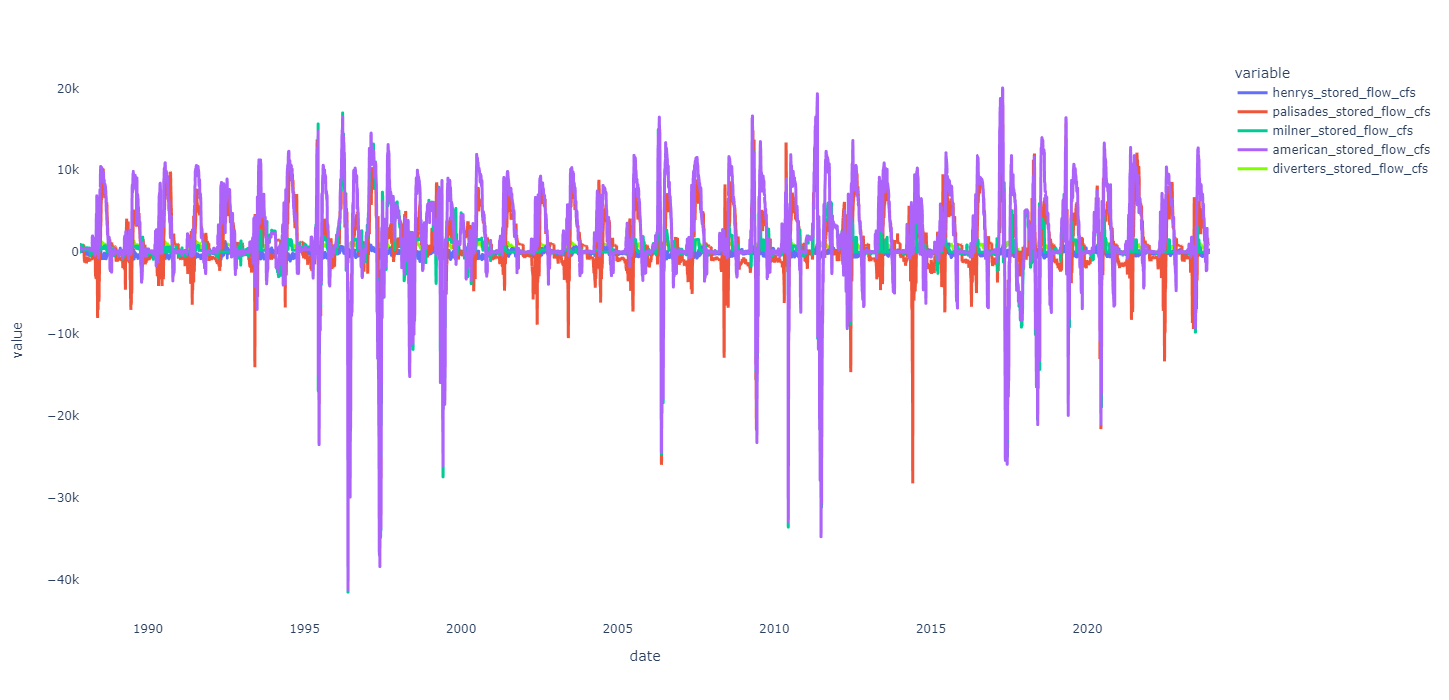

In [12]:
## add all lines to this data
import plotly.express as px
#fig = px.line(master_data, x="date", y="diverters_flow_cfs", title='Flows')
fig = px.line(master_data, x="date", y=master_data.columns[1:6])
fig.add_scatter(x=master_data['date'], y=master_data['diverters_stored_flow_cfs'], name='diverters_stored_flow_cfs',\
               marker=dict(color="Chartreuse"))
fig.update_traces(line={'width': 3})
fig.update_layout(
    showlegend=True,
    plot_bgcolor="white",
    width=1400,
    height=700
)

In [8]:
## Plot by year


## Climate

In [9]:
up_snake_precip = pd.read_csv('data/upper_snake_WY_avg_cum_precip_1896-2020.csv', skiprows=0).set_index('Year')
up_snake_temp = pd.read_csv('data/upper_snake_WY_mean_temp_1896-2020.csv', skiprows=0).set_index('Year')
up_snake_SPEI = pd.read_csv('data/upper_snake_WY_SPEI_1896-2020.csv', skiprows=0).set_index('Year')
up_snake = pd.concat([up_snake_precip['Precipitation (Inches)'], up_snake_temp['Temperature (Degrees F)'], up_snake_SPEI['Data']], axis =1)
up_snake = up_snake.rename(columns={'Data': 'SPEI'})
up_snake

Precipitation (Inches)  Temperature (Degrees F)  SPEI
Year                                                       
1896                   18.03                    40.99  0.16
1897                   17.06                    41.58 -0.58
1898                   17.35                    41.36 -0.40
1899                   14.53                    39.43 -0.40
1900                   13.13                    42.96 -1.32
...                      ...                      ...   ...
2016                   19.95                    43.16 -0.19
2017                   28.18                    42.81  1.24
2018                   18.51                    43.17 -0.47
2019                   22.94                    41.28  0.88
2020                   14.07                    42.33 -1.33

[125 rows x 3 columns]

## Archive

In [10]:
## Reach ##
## Willow Creek ##

## Major Users ##
# NA

In [11]:
#cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=DWRDBINTRANET\PROD;DATABASE=Enterprise64;UID=edbread;PWD=readonly')
#cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=DWRDBPUBLIC\GIS;DATABASE=WaterAccounting;UID=edbread;PWD=readonly')#Trusted_Connection=True;
#cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=DWRDBPUBLIC\GIS;DATABASE=WaterAccounting;Trusted_Connection=True')#Trusted_Connection=True;